# Image-Based Flower Classification

### Luis R. Reyes

luis.ra.reyes@gmail.com

---

## Relevant Libraries

In [ ]:

# Relevant libraries

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import tarfile
import urllib
import cv2
import os
import re

%matplotlib inline 
#

## Data Retrieval

In [ ]:

# Data retrieval (Desktop wil be used as workspace.)

def get_data():
    
    url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"
    print ("\ndownloading flower images...")    
    filename, headers = urllib.request.urlretrieve(
        url,filename=os.path.expanduser("~/Desktop/17flowers.tgz"))    
    print ("download complete!")

    os.chdir(os.path.expanduser("~/Desktop/"))
    print ("extracting flower images...")
    tar = tarfile.open(os.path.expanduser("~/Desktop/17flowers.tgz"), "r:gz")
    tar.extractall()
    tar.close()
    print ("extract complete!")
    
    print ("downloading tensorflow component...")
    urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorflow/models/master/tutorials/image/imagenet/classify_image.py",
                           filename=os.path.expanduser("~/Desktop/classify_image.py"))
    print ("download complete!")
    
    os.chdir(os.path.expanduser("~/Desktop/"))
    print ("generating graph...")
    os.system("python classify_image.py --model_dir ~/Desktop/graph/")
    print ("graph complete!\n")

get_data()

#

## Data Prep

In [12]:
# Classes

classes = ['Daffodil','Snowdrop', 'Lily Valley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'Colts Foot',
            'Dandelalion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']

y = np.repeat(classes, 80)

#

# Image files

images = []
loc = os.path.expanduser("~/Desktop/jpg")

for filename in sorted(os.listdir(loc)):
    
    img = cv2.imread(os.path.join(loc,filename))    
    
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

images = np.asarray(images)

#

## Tensor Prep

In [13]:
# Tensor prep

path = os.path.expanduser("~/Desktop/jpg")
files = sorted(os.listdir(path))
i = 1

for file in files:    # Rename image files
    if re.search("jpg", file):        
        os.rename(os.path.join(path, file), os.path.join(path, y[i-1]+'_'+str(i)+'.jpg'))
        i = i+1     
#

# Tensorflow

model_dir = os.path.expanduser("~/Desktop/graph/") 
os.chdir(os.path.expanduser("~/Desktop/"))
images_dir = "jpg/"

list_images = [images_dir+f for f in os.listdir(images_dir) if re.search("jpg", f)] # List of new image filenames


tmp = []

for i in range(len(list_images)): # Retrieve numbers from filenames
    
    t = re.findall(r"\d+", list_images[i])
    tmp.append(int(t[0]))

list_images = [x for (y,x) in sorted(zip(tmp,list_images))] # Order image files by number


def create_graph(): # Create instance of the trained model
    
    with tf.gfile.FastGFile(os.path.join(model_dir, "classify_image_graph_def.pb"), "rb") as f:
        
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

def extract_features(list_images):
    
    nb_features = 2048
    features = np.empty((len(list_images), nb_features))
    labels = []
    
    create_graph() # Initiate instance of the trained model
    sess = tf.Session() # Open session
    penultimate_tensor = sess.graph.get_tensor_by_name('pool_3:0') # Retrieve penultimate layer
    
    for i in range(len(list_images)): # Feed image into layer and retrieve features and label
        
        if (i%100 == 0):
            print("Processing %s..." % (list_images[i]))
            
        preds = sess.run(penultimate_tensor,
                           {'DecodeJpeg:0': images[i]})
        features[i,:] = np.squeeze(preds)
        labels.append(re.split("_\d+",list_images[i].split("/")[1])[0])

    sess.close() # Close session    
        
    return features, labels

features, labels = extract_features(list_images)

#

Processing jpg/Daffodil_1.jpg...
Processing jpg/Snowdrop_101.jpg...
Processing jpg/Lily Valley_201.jpg...
Processing jpg/Bluebell_301.jpg...
Processing jpg/Iris_401.jpg...
Processing jpg/Tigerlily_501.jpg...
Processing jpg/Tulip_601.jpg...
Processing jpg/Fritillary_701.jpg...
Processing jpg/Daisy_801.jpg...
Processing jpg/Colts Foot_901.jpg...
Processing jpg/Dandelalion_1001.jpg...
Processing jpg/Cowslip_1101.jpg...
Processing jpg/Windflower_1201.jpg...
Processing jpg/Pansy_1301.jpg...


## Model Selection

In [14]:
#

model = LinearSVC(C=1, loss='squared_hinge', penalty='l2',multi_class='ovr')

#

## Model Performance


Linear SVC Accuracy (Ten-Fold CV): 0.9514705882352942 

Linear SVC Accuracy (Holdout Set): 0.9436274509803921 

Linear SVC Classification Report: 

             precision    recall  f1-score   support

   Daffodil       0.96      0.96      0.96        24
   Snowdrop       1.00      0.95      0.98        21
Lily Valley       0.95      0.91      0.93        23
   Bluebell       1.00      0.88      0.94        26
     Crocus       0.96      0.96      0.96        27
       Iris       0.87      0.87      0.87        23
  Tigerlily       1.00      1.00      1.00        22
      Tulip       0.94      0.84      0.89        19
 Fritillary       1.00      0.93      0.97        30
  Sunflower       1.00      1.00      1.00        24
      Daisy       0.87      0.87      0.87        23
 Colts Foot       1.00      1.00      1.00        30
Dandelalion       0.82      0.92      0.87        25
    Cowslip       0.96      1.00      0.98        24
  Buttercup       0.96      0.96      0.96        24
 W

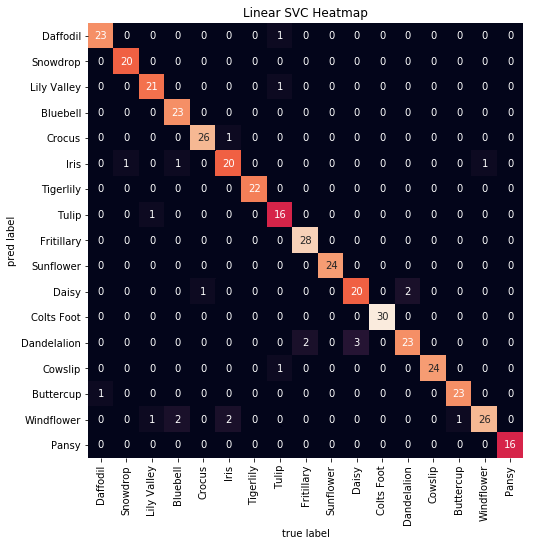

In [15]:
# Linear SVC performance/results 

Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels,
                                                random_state = 7,
                                                test_size = 0.3
                                                )

model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

print("\nLinear SVC Accuracy (Ten-Fold CV):", cross_val_score(model, features, labels, cv=10).mean(), "\n")

print("Linear SVC Accuracy (Holdout Set):", accuracy_score(ytest, ypred), "\n")

print("Linear SVC Classification Report:", "\n")

print(classification_report(ytest, model.predict(Xtest), 
                            target_names = classes))

plt.figure(figsize=(8, 8))
mat = confusion_matrix(ytest, ypred)
ax = sns.heatmap(mat.T, square = True, annot = True, fmt='d', cbar=False,
            xticklabels = classes, yticklabels= classes)
plt.xlabel('true label')
plt.ylabel('pred label')
plt.title('Linear SVC Heatmap')
plt.show();

#